In [1]:
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

print('we are currently using tensorflow version', tf.__version__)

2024-04-15 12:02:51.436205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 12:02:52.922334: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Setting up an environment</h1>

In [2]:
input_shape_2D=(250,250)
input_shape_3D= (250,250,3)
seeds=41
batch_size=32
epochs=10

In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/train',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 2100 files belonging to 6 classes.


2024-04-15 12:02:59.206927: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 12:02:59.332078: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-15 12:02:59.332417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
valid_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/validation',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seeds
)

Found 528 files belonging to 6 classes.


In [5]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">Data Processing</h1>

In [6]:
X=[]
y= []

for image, label in data_ds.batch(2099):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [9]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [10]:
from sklearn.model_selection import train_test_split

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seeds)

# Normalisation

In [11]:
X_train = X_train/255
X_test = X_test/255

In [12]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1680, 250, 250, 3)
shape of y_train: (1680,)
shape of X_test_scaled: (420, 250, 250, 3)
shape of y_test: (420,)


# Encoding

In [13]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

<h1 style="font-family:verdana; color:#228B22; background-color:#FFFFE0;text-align: center;">CNN Architecture</h1>

# Inception model 

In [14]:
from keras.layers import Input, Conv2D, DepthwiseConv2D, Concatenate, Add, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D

def inception_module(x, filters):
    # Branch 1:1 x1 convolution
    branch_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(x)

    # Branch 2: depth-separable convolution (3x3)
    branch_3x3 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)
    branch_3x3 = Conv2D(filters=filters[1], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_3x3)

    # Branch 3: Depth-separable Convolution (5x5)
    branch_5x5 = DepthwiseConv2D(kernel_size=(5, 5), strides=1, padding='same', activation='relu')(x)
    branch_5x5 = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_5x5)

    # The branch 4:3x3 is maximized and then convolved with 1x1
    branch_pool = AveragePooling2D(pool_size=(3, 3), strides=1, padding='same')(x)
    branch_pool = Conv2D(filters=filters[3], kernel_size=(1, 1), strides=1, padding='same', activation='relu')(branch_pool)

    output = Concatenate(axis=-1)([branch_1x1, branch_3x3, branch_5x5, branch_pool])
    return output

def residual_block(x, filters):
    # Save the input for subsequent residual connections
    shortcut = x

    # The first Inception module
    x = inception_module(x, filters)

    # The Second Inception module
    x = inception_module(x, filters)

    # If the input and output dimensions do not match, the dimensions are adjusted using 1x1 convolution
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv2D(filters=x.shape[-1], kernel_size=(1, 1), strides=1, padding='same')(shortcut)

    # Residual connection
    x = Add()([shortcut, x])
    x = tf.keras.layers.Activation('relu')(x)
    return x

# Input Layer
input_layer = Input(shape=(250, 250, 3))

# Convolution layer
conv1 = Conv2D(64, (5, 5), strides=(2, 2), padding='same', activation='relu')(input_layer)

# Residual block
res_block1 = residual_block(conv1, [32, 64, 128, 32])
res_block2 = residual_block(res_block1, [64, 64, 128, 32])

pool2 = GlobalAveragePooling2D()(res_block2)
dense = Dense(2048, activation='relu')(pool2)
# Fully connected layer
flatten = Flatten()(dense)

output_layer = Dense(6, activation='softmax')(flatten)

model = Model(inputs=input_layer, outputs=output_layer)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 250, 250, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 125, 125, 64)         4864      ['input_1[0][0]']             
                                                                                                  
 depthwise_conv2d (Depthwis  (None, 125, 125, 64)         640       ['conv2d[0][0]']              
 eConv2D)                                                                                         
                                                                                                  
 depthwise_conv2d_1 (Depthw  (None, 125, 125, 64)         1664      ['conv2d[0][0]']          

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
import time
# Record the start time of training
start_time = time.time()

In [18]:
# Train the model
epochs = 10

#Callback to save the best model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='Depth_Incep_Res_model.h5',
        monitor='val_loss', save_best_only=True, verbose=1)
]

#Training
history=model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=epochs)

Epoch 1/10


2024-04-15 12:04:03.889653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-15 12:04:10.664280: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-15 12:04:11.118537: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f2bd4002fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 12:04:11.118771: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-04-15 12:04:11.291344: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 12:04:12.019936: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

53/53 [==============================] - 67s 726ms/step - loss: 1.2318 - accuracy: 0.5262 - val_loss: 1.8385 - val_accuracy: 0.2714
Epoch 2/10
53/53 [==============================] - 36s 676ms/step - loss: 1.0215 - accuracy: 0.6167 - val_loss: 1.8877 - val_accuracy: 0.2429
Epoch 3/10
53/53 [==============================] - 34s 639ms/step - loss: 1.0274 - accuracy: 0.6476 - val_loss: 1.7023 - val_accuracy: 0.2786
Epoch 4/10
53/53 [==============================] - 36s 682ms/step - loss: 0.8475 - accuracy: 0.7012 - val_loss: 1.7371 - val_accuracy: 0.1810
Epoch 5/10
53/53 [==============================] - 34s 641ms/step - loss: 0.8611 - accuracy: 0.6845 - val_loss: 1.5573 - val_accuracy: 0.2214
Epoch 6/10
53/53 [==============================] - 34s 641ms/step - loss: 0.8089 - accuracy: 0.7143 - val_loss: 2.0570 - val_accuracy: 0.1905
Epoch 7/10
53/53 [==============================] - 34s 641ms/step - loss: 0.7160 - accuracy: 0.7411 - val_loss: 2.2705 - val_accuracy: 0.3381
Epoch 8/10

In [19]:
# Record the training end time
end_time = time.time()

In [20]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 395.23845314979553 seconds


In [21]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.231801,0.526190,1.838484,0.271429
1,1.021508,0.616667,1.887738,0.242857
2,1.027353,0.647619,1.702271,0.278571
3,0.847518,0.701190,1.737107,0.180952
4,0.861053,0.684524,1.557294,0.221429
5,0.808878,0.714286,2.056956,0.190476
6,0.716005,0.741071,2.270493,0.338095
7,0.702234,0.739881,1.314629,0.250000
8,0.638297,0.782143,2.976337,0.240476
9,0.654955,0.761310,1.023105,0.678571


In [27]:
model.save("DepthWiseInceptionResNet_Version1.h5")

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
import joblib

joblib.dump(history.history,'history_DepthWiseInceptionResNet.pkl')
history_CNN1 = joblib.load('history_DepthWiseInceptionResNet.pkl')

In [23]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.tight_layout()

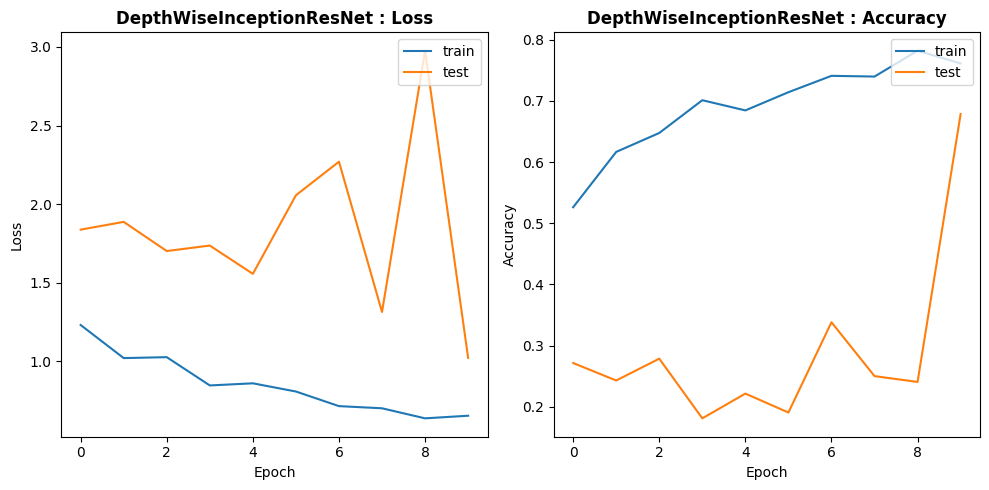

In [24]:
plot_performance(model_name='DepthWiseInceptionResNet',
                acc=history_CNN1['accuracy'], 
                 val_acc=history_CNN1['val_accuracy'],
                 loss=history_CNN1['loss'], 
                 val_loss=history_CNN1['val_loss'])

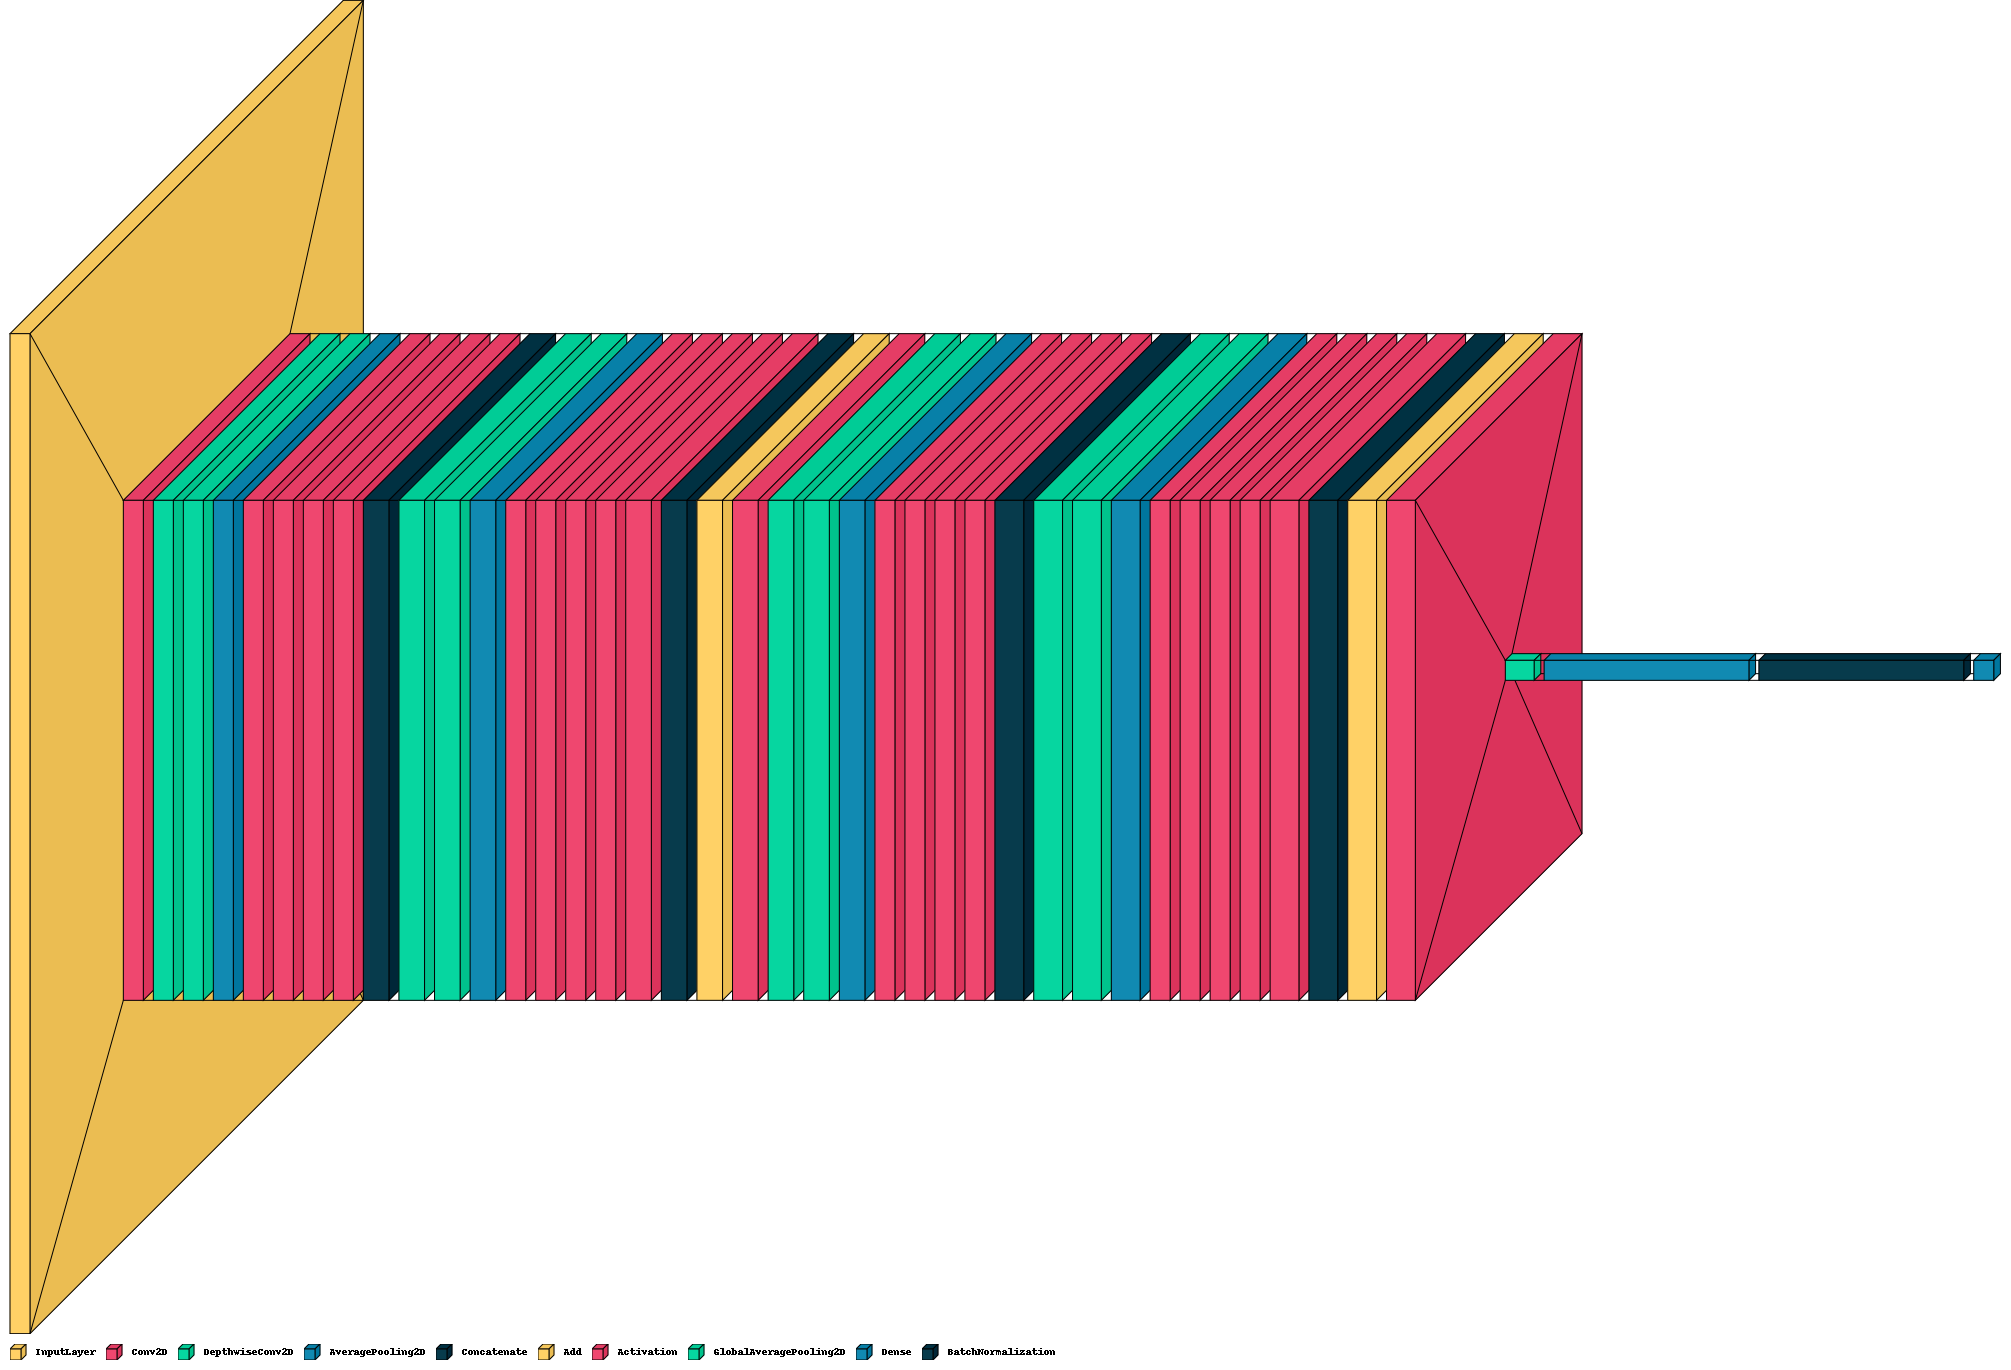

In [25]:
import visualkeras

visualkeras.layered_view(model,  legend=True)

In [30]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [31]:
#You need to install numba using 'pip install numba'

from numba import cuda

cuda.select_device(0)
cuda.close()